23 TE01378
['direction', 'temp', 'Sn_ratio', 'Se_ratio', 'Na_ratio', 'Cl_ratio', 'dopant_num', 'dopant_ratio'] dopantremove
electrical_conductivity
num of features: 8
Average train loss: 0.4079, r2: 0.9997, Average test loss: 11.8127, r2: 0.6579
seebeck_coeff
num of features: 8
Average train loss: 1.5789, r2: 0.9999, Average test loss: 35.3144, r2: 0.9247
thermal_conductivity
num of features: 8
Average train loss: 0.0070, r2: 0.9980, Average test loss: 0.0845, r2: 0.7802
ZT errors:  0.1618 0.1090 0.6217

0 0
['direction', 'temp', 'ion', 'covalent', 'vdw', 'atomic_radius', 'pauling_en', 'en_allen', 'polarizability', 'melting_point', 'boiling_point', 'density', 'specific_heat', 'thermal_conductivity', 'Sn_ratio', 'Se_ratio', 'Na_ratio', 'Cl_ratio', 'dopant_num', 'dopant_ratio'] dopantremove
electrical_conductivity
num of features: 20
Average train loss: 0.1674, r2: 0.9999, Average test loss: 12.7671, r2: 0.5594
seebeck_coeff
num of features: 20
Average train loss: 0.6987, r2: 1.0000, Ave

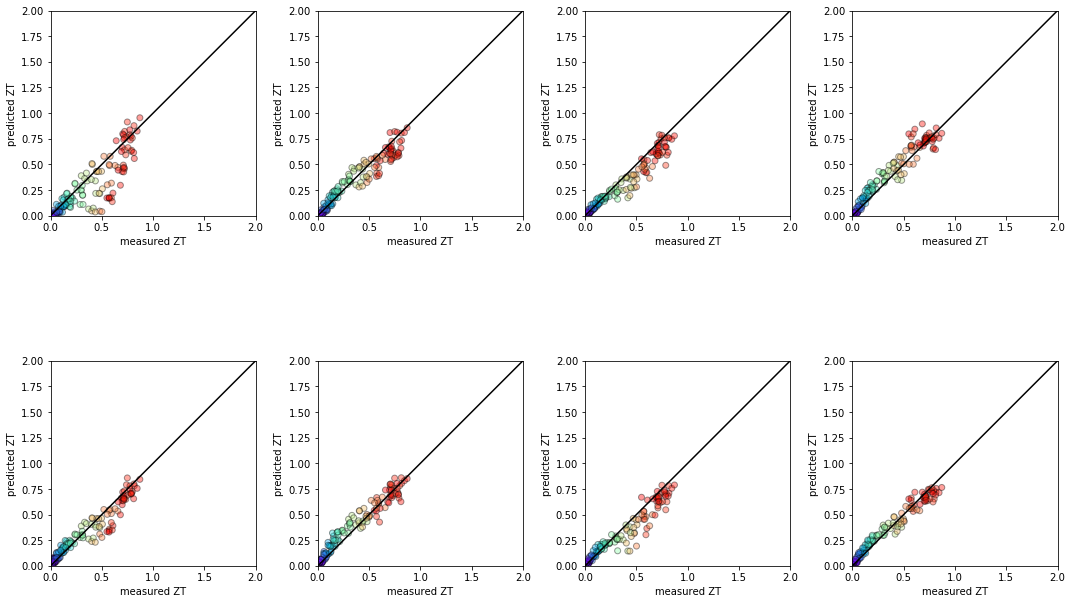

               test_MAE test_R2
dopant remove
basic            0.1090 0.6217
basic+atomic     0.0627 0.8802
basic+DFT        0.0620 0.8591
basic+atomic+DFT 0.0606 0.9127

dopant remove, one sample exist
basic            0.0607 0.8766
basic+atomic     0.0567 0.9190
basic+DFT        0.0649 0.8395
basic+atomic+DFT 0.0485 0.9375


In [1]:
import numpy
import copy

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from joblib import dump, load

import util
from util import KFold
from util import cut_feature
from util import calculate_ZT
from util import dopant_list
from util import scatterplot

%matplotlib inline



measureset=['electrical_conductivity','seebeck_coeff','thermal_conductivity']

#given feature set

column=['direction','temp',\
          'vbm_e','vbm_e2','vbm_e3',\
          'cbm_e','cbm_e2','cbm_e3','magnetism','deep_level',\
          'vbm_org_1', 'vbm_org_2','vbm_org_3','cbm_org_1','cbm_org_2','cbm_org_3',\
          'vbm_m','vbm_m2','vbm_m3','cbm_m','cbm_m2','cbm_m3',\
          'vbm_e_sn','vbm_e2_sn','vbm_e3_sn','cbm_e_sn','cbm_e2_sn','cbm_e3_sn',\
          'vbm_e_se','vbm_e2_se','vbm_e3_se','cbm_e_se','cbm_e2_se','cbm_e3_se',\
          'vbm_m_sn', 'vbm_m2_sn','vbm_m3_sn','cbm_m_sn','cbm_m2_sn','cbm_m3_sn',\
          'vbm_m_se', 'vbm_m2_se','vbm_m3_se','cbm_m_se','cbm_m2_se','cbm_m3_se',\
          'bandgap','bandgap_sn', 'bandgap_se', 'bandgap_rate',\
          'ion','covalent','vdw','atomic_radius','pauling_en','en_allen','polarizability','melting_point',\
          'boiling_point','density','specific_heat','thermal_conductivity',\
          'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio']  

featureset= [['direction','temp',\
          'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio'],\
            ['direction','temp',\
          'ion','covalent','vdw','atomic_radius','pauling_en','en_allen','polarizability','melting_point',\
          'boiling_point','density','specific_heat','thermal_conductivity',\
          'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio'],\
            ['direction','temp',\
          'magnetism','deep_level',\
             'vbm_org_1', 'vbm_org_2','vbm_org_3','cbm_org_1','cbm_org_2','cbm_org_3',\
          'vbm_m','vbm_m2','vbm_m3','cbm_m','cbm_m2','cbm_m3',\
          'vbm_e_sn','vbm_e2_sn','vbm_e3_sn','cbm_e_sn','cbm_e2_sn','cbm_e3_sn',\
          'vbm_e_se','vbm_e2_se','vbm_e3_se','cbm_e_se','cbm_e2_se','cbm_e3_se',\
          'vbm_m_sn', 'vbm_m2_sn','vbm_m3_sn','cbm_m_sn','cbm_m2_sn','cbm_m3_sn',\
          'vbm_m_se', 'vbm_m2_se','vbm_m3_se','cbm_m_se','cbm_m2_se','cbm_m3_se',\
          'bandgap','bandgap_sn', 'bandgap_se', 'bandgap_rate',\
          'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio'],\
            ['direction','temp',\
          'magnetism','deep_level',\
          'vbm_org_1', 'vbm_org_2','vbm_org_3','cbm_org_1','cbm_org_2','cbm_org_3',\
          'vbm_m','vbm_m2','vbm_m3','cbm_m','cbm_m2','cbm_m3',\
          'vbm_e_sn','vbm_e2_sn','vbm_e3_sn','cbm_e_sn','cbm_e2_sn','cbm_e3_sn',\
          'vbm_e_se','vbm_e2_se','vbm_e3_se','cbm_e_se','cbm_e2_se','cbm_e3_se',\
          'vbm_m_sn', 'vbm_m2_sn','vbm_m3_sn','cbm_m_sn','cbm_m2_sn','cbm_m3_sn',\
          'vbm_m_se', 'vbm_m2_se','vbm_m3_se','cbm_m_se','cbm_m2_se','cbm_m3_se',\
          'bandgap','bandgap_sn', 'bandgap_se', 'bandgap_rate',\
           'ion','covalent','vdw','atomic_radius','pauling_en','en_allen','polarizability','melting_point',\
          'boiling_point','density','specific_heat','thermal_conductivity',\
          'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio']]



# hyperparameters
num_feats=len(column)
num_folds = 5

#selected samples for a given dopant
pickup=[[23,'TE01378']]
ddd=-1
pickup_loss=numpy.zeros((len(pickup),8,3))
iii=0
filename_in=['dopantremove','dopantremove_exist']

#predicting errors depending on the existence of the given dopant
for drop_num,chosen in pickup:
    print(drop_num,chosen)
    util.dopantremove(drop_num,chosen)
    jjj=0
    ddd+=1
    for file in filename_in: # training without chosen dopant samples & with only one sample

        for feature in featureset:
            print(feature, file)

        # load training dataset
            for measure in measureset:

                best_loss = 10000000
                load_file = './outputdata_V_test/training_features_'+str(measure)+'_'+ str(file)+'.csv'
                data_dict = util.load_data(load_file)
                print(measure)
                print('num of features:', len(feature))
                
                # generate k-fold training dataset
                kfold = KFold(data_dict, num_feats, num_folds, normalization=False)

                filename_best = str(measure) + '_best.joblib'


                # define default model
                if measure == 'electrical_conductivity':
                    default_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=500)  #XGB
                elif measure == 'seebeck_coeff':
                    default_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=400)  #XGB
                elif measure == 'thermal_conductivity':
                    default_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=400)  #XGB


                # evaluate model using k-fold cross-validation
                sum_test_mae = 0;sum_train_mae = 0;sum_test_r2 = 0;sum_train_r2 = 0
                total_train_in=[]; total_train_out=[];    total_test_in=[];    total_test_out=[]

                temp = copy.deepcopy(column)
                temp2=[]

                #remove feature columns
                for j in feature:
                    temp.remove(j)

                for k in temp:
                    temp2.append(column.index(k))
                temp2.sort(reverse=True)

                #training
                for k in range(0, num_folds):
                    model = copy.deepcopy(default_xgb)
                    train_dataset, test_dataset = kfold.get(k)
                    train_data_x = train_dataset[:, :num_feats]
                    train_data_y = train_dataset[:, num_feats].reshape(-1, 1)
                    test_data_x = test_dataset[:, :num_feats]
                    test_data_y = test_dataset[:,num_feats]

                    train_data_x_in = copy.deepcopy(train_data_x)
                    test_data_x_in = copy.deepcopy(test_data_x)            

                    #remove useless feature columns
                    for j in temp2:
                        train_data_x_in = numpy.delete(train_data_x_in,j,axis=1)
                        test_data_x_in  = numpy.delete(test_data_x_in,j,axis=1)           

                    X_train_model, Y_train_model = shuffle(train_data_x_in,train_data_y, random_state=423)

                    model.fit(X_train_model, Y_train_model, eval_metric='mae', eval_set=[(X_train_model,Y_train_model)],verbose=None)  #Xgb

                    filename = './outputdata_V_test/'+str(measure) + '_'+str(k)+"_dopant.joblib"

                    dump(model, filename)

                    train_mae, train_r2 = util.pred_train_ML(model,train_data_x_in,train_dataset,total_train_in, total_train_out, num_feats)
                    test_mae, test_r2   = util.pred_test_ML(model, num_feats, test_data_x_in,test_data_y, total_test_in, total_test_out)

                    sum_test_mae  += test_mae
                    sum_train_mae += train_mae
                    sum_train_r2  += train_r2
                    sum_test_r2   += test_r2


                # average test in k-fold cross-validation
                print('Average train loss: {:.4f}, r2: {:.4f}, Average test loss: {:.4f}, r2: {:.4f}'.format(sum_train_mae/num_folds, \
                        sum_train_r2/num_folds, sum_test_mae / num_folds, sum_test_r2/num_folds))


            column2=['id']+column+['K']
            
            thermo  = pd.read_csv('./outputdata_V_test/zt_dataset_' +str(file)+'.csv', index_col=0)
            target = thermo.K.values
            test_data_x = pd.read_csv('./outputdata_V_test/zt_test_features_' +str(file)+'.csv', index_col=0).values


            iii=0
            predicted=numpy.zeros((len(measureset),thermo.shape[0]))


            for measure in measureset:
                testin=cut_feature(column2,feature, test_data_x)
                
                for kkk in range(num_folds):

                    filename = './outputdata_V_test/'+str(measure) + "_" +  str(kkk) + "_dopant.joblib"
                    
                    clf = load(filename)
                    predicted[iii,:] += clf.predict(testin)
                iii+=1


            predicted /= num_folds
            temp = thermo.Temp
            ZT=calculate_ZT(predicted,temp,target,thermo, True, './outputdata_V_test/zt_test_dopant_'+str(jjj)+'.csv')


            X_train=dopant_list(thermo) # dopant list rearrangement
            target = thermo.K.values
            temp = thermo.Temp.values

            #scatterplot(target,ZT,temp,'Temperature','zt_temp_dopant.pdf')


            rmse_train = numpy.sqrt(mean_squared_error(target, ZT))

            mae_train = mean_absolute_error(target,ZT)

            r2score_train = r2_score(ZT, target)

            print('ZT errors: ', "%.4f" % rmse_train,"%.4f" % mae_train,"%.4f" % r2score_train)
            print()
            print(ddd,jjj)

            pickup_loss[ddd][jjj][0]=rmse_train
            pickup_loss[ddd][jjj][1]=mae_train
            pickup_loss[ddd][jjj][2]=r2score_train
            jjj += 1          
            
    fig = plt.figure(figsize=(15,15))

    for j in range(8):    
        
        ax0 = fig.add_subplot(2, 4, j+1)
        ax0.set_xlim((0,2))
        ax0.set_ylim((0,2))
        ax0.set_xlabel('measured ZT')
        ax0.set_ylabel('predicted ZT')



        x = numpy.linspace(-15000, 15000, 10)
        ax0.plot(x,x,color='black')
        ax0.set_aspect('equal')


        final  = pd.read_csv('./outputdata_V_test/zt_test_dopant_'+str(j)+ '.csv', index_col=0)
        target = final.K.values
        zt = final.ZT.values
        temp = final.Temp.values

        ax0.scatter(target,zt,alpha=0.4,c=temp,edgecolors='black', cmap=plt.cm.rainbow) #
        plt.tight_layout()

        rmse_train = numpy.sqrt(mean_squared_error(target, zt))

        mae_train = mean_absolute_error(target,zt)

        r2score_train = r2_score(zt, target)

        
    plt.show()
    fig.savefig('./outputdata_V_test/feature_test_'+str(drop_num)+'.pdf', format='pdf')
        


    print('              ','test_MAE', 'test_R2')
    print('dopant remove')
    i=0
    print('basic           ',           "%.4f"%pickup_loss[i][0][1],"%.4f"%pickup_loss[i][0][2])
    print('basic+atomic    ',    "%.4f"%pickup_loss[i][1][1],"%.4f"%pickup_loss[i][1][2])
    print('basic+DFT       ',       "%.4f"%pickup_loss[i][2][1],"%.4f"%pickup_loss[i][2][2])
    print('basic+atomic+DFT',"%.4f"%pickup_loss[i][3][1],"%.4f"%pickup_loss[i][3][2])
    print()
    print('dopant remove, one sample exist')
    print('basic           ',           "%.4f"%pickup_loss[i][4][1],"%.4f"%pickup_loss[i][4][2])
    print('basic+atomic    ',    "%.4f"%pickup_loss[i][5][1],"%.4f"%pickup_loss[i][5][2])
    print('basic+DFT       ',       "%.4f"%pickup_loss[i][6][1],"%.4f"%pickup_loss[i][6][2])
    print('basic+atomic+DFT',"%.4f"%pickup_loss[i][7][1],"%.4f"%pickup_loss[i][7][2])
    
